In [7]:
import numpy as np
import Terms 
import celerite2
import matplotlib.pyplot as plt

In [8]:
def fn(x, sigma, t0):
    return np.exp(-(x - t0)**2 / (2 * sigma**2))

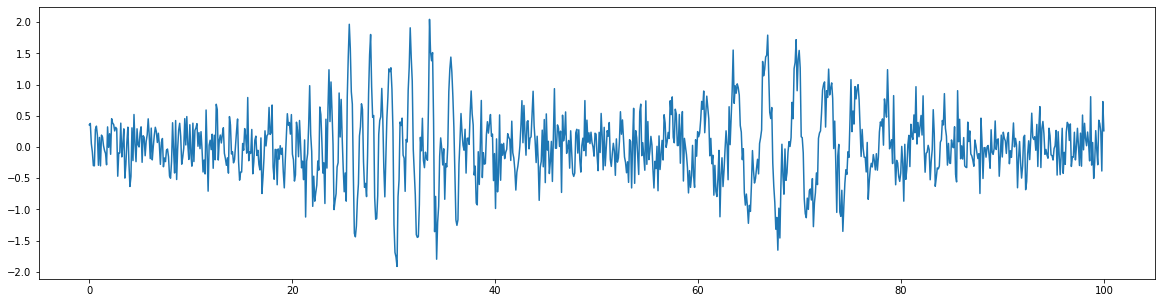

In [9]:
k1 = Terms.NSTerm(celerite2.terms.RotationTerm(f=0.5, Q0=100, dQ=0.0, period=2, sigma=1), lambda x: fn(x, 10, 30))
k2 = Terms.NSTerm(celerite2.terms.RotationTerm(f=0.5, Q0=100, dQ=0.0, period=3, sigma=1), lambda x: fn(x, 10, 70))

t = np.linspace(0, 100, 1000)
gp = celerite2.GaussianProcess(k1 + k2, t, diag=0.1)
y = gp.sample()

plt.figure(figsize=(20, 5))
plt.plot(t, y, '-')
plt.savefig('/Users/tgordon/Desktop/nonstationary_noisy.pdf')

In [10]:
from scipy.optimize import minimize

def buildgp(params):
    
    mean, diag, f1, Q01, dQ1, period1, sigma1, sigf1, tf1, f2, Q02, dQ2, period2, sigma2, sigf2, tf2 = params
    
    k1 = Terms.NSTerm(
        celerite2.terms.RotationTerm(
            f=f1, Q0=Q01, dQ=dQ1, period=period1, sigma=sigma1
        ), 
        lambda x: fn(x, sigf1, tf1)
    )
    k2 = Terms.NSTerm(
        celerite2.terms.RotationTerm(
            f=f2, Q0=Q02, dQ=dQ2, period=period2, sigma=sigma2
        ), 
        lambda x: fn(x, sigf2, tf2)
    )
    gp = celerite2.GaussianProcess(k1 + k2, t, mean=mean, diag=diag)
    return gp


def neg_log_like(params):
    try:
        gp = buildgp(params)
        ll = gp.log_likelihood(y)
    except:
        ll = -np.inf
    return -ll


initial_params = [0.0, 0.1, 0.5, 100, 0.0, 2, 1, 10, 30, 0.5, 100, 0.0, 3, 1, 10, 70]
soln = minimize(neg_log_like, initial_params)

/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [11]:
import emcee

def prior(params):
    
    mean, diag, f1, Q01, dQ1, period1, sigma1, sigf1, tf1, f2, Q02, dQ2, period2, sigma2, sigf2, tf2 = params
    
    if ((period1 > 0) 
        & (period2 > 0) 
        & (sigf1 > 0) 
        & (sigf2 > 0) 
        & (diag > 0) 
        & (f1 > 0) 
        & (f2 > 0) 
        & (sigma1 > 0) 
        & (sigma2 > 0)
       ):
        return 0.0
    else:
        return -np.inf
    

def log_prob(params):
    
    pr = prior(params)
    if pr == 0.0:
        gp = buildgp(params)
        ll = gp.log_likelihood(y)
        if not np.isnan(ll):
            return ll
        else:
            return - np.inf
    else:
        return -np.inf

In [12]:
coords = soln.x + 1e-5 * np.random.randn(64, len(soln.x))
sampler = emcee.EnsembleSampler(
    coords.shape[0], coords.shape[1], log_prob
)
state = sampler.run_mcmc(coords, 1000, progress=True)
sampler.reset()
state = sampler.run_mcmc(state, 1000, progress=True)

 34%|███▎      | 337/1000 [00:19<00:35, 18.93it/s]/usr/local/lib/python3.8/site-packages/celerite2/terms.py:803: RuntimeWarning: invalid value encountered in sqrt
  w2 = 8 * np.pi * Q2 / (self.period * np.sqrt(4 * Q2 ** 2 - 1))
 88%|████████▊ | 876/1000 [00:47<00:06, 19.15it/s]/usr/local/lib/python3.8/site-packages/celerite2/terms.py:798: RuntimeWarning: invalid value encountered in sqrt
  w1 = 4 * np.pi * Q1 / (self.period * np.sqrt(4 * Q1 ** 2 - 1))
100%|██████████| 1000/1000 [00:48<00:00, 20.56it/s]


In [13]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
some_params_samples = flat_samples[:, [5, 7, 8, 12, 14, 15]]
labels=[r'$P_1$', r'$\sigma_1$', r'$\mu_1$', r'$P_2$', r'$\sigma_2$', r'$\mu_2$']
truths = [2, 10, 30, 3, 10, 70]

fig = corner.corner(some_params_samples, labels=labels, truths=truths);
plt.savefig('/Users/tgordon/Desktop/nonstationary_corner_noisy.pdf')

NameError: name 'corner' is not defined